In [280]:
# Run but do not modify this code
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge


## Data Munging
from sklearn.preprocessing import OneHotEncoder

## Measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()

In [281]:
import pandas as pd
sns.set_theme()
tumor_df = pd.read_csv("tumor_data.csv")
print(tumor_df.shape)
tumor_df.head()

(323, 18)


,DeID,Ethnicity,Biomarker,TumorType,ER,Her2,Grade,GradeT,GradeN,GradeM,Tsizemm,Age,TILs,mits,Age50,grade1,TILs20,Tsize60
0,1,1,1,ductal,1,0,3,2,3,3,70.0,61,13,18,1,1,0,1
1,2,1,1,ductal,1,0,2,3,2,2,999.0,52,11,13,1,0,0,999
2,3,1,1,mucinous or mucinous fx\t,1,0,1,2,2,1,999.0,65,15,2,1,0,0,999
3,4,1,1,micropap or micropap fx\t,1,0,2,3,2,1,999.0,55,20,7,1,0,0,999
4,5,1,1,cribriform\t,1,0,1,1,2,2,90.0,74,7,13,1,0,0,1


In [282]:
# Features: Tumor type, HER2 and ER status, and grade of the tumor
# Target Variable: Tumor size

# Filter original dataframe to drop all rows with 999
cleaned_df = tumor_df[(tumor_df != 999).all(axis=1)]

# Original dataframe filtered by ethnicity
tanzania_df = tumor_df[tumor_df['Ethnicity'] == 1]
black_american_df = tumor_df[tumor_df['Ethnicity'] == 2]
white_american_df = tumor_df[tumor_df['Ethnicity'] == 3]

df_list = [(tanzania_df, 'Tanzanian'), (black_american_df, 'Black American'), (white_american_df, 'White American')]

# Prints the length and number of rows with 999 in the each ethnicity-filtered dataframe
for df, ethnicity in df_list:
    num_rows_with_999 = len(df[df.isin([999]).any(axis=1)])
    print(f"DataFrame {ethnicity}: Length: {len(df)}, Number of rows with 999: {num_rows_with_999}")

''' 
Following block of code only applies to tanzania_df
The code keeps the rows where none of the columns in 
columns_to_check (all columns except 'Tsizemm' and 'Tsize60') have a value of 999
'''
columns_to_check = tanzania_df.columns.difference(['Tsizemm', 'Tsize60'])
tanzania_df = tanzania_df[~(tanzania_df[columns_to_check] == 999).any(axis=1)]
columns_with_999 = tanzania_df.columns[tanzania_df.isin([999]).any()].tolist()

# Print all columns with 999 value in tanzania_df
print("Columns with 999 value:", columns_with_999)

# Replace all 999 values with NAs in new tanzania_df
tanzania_df.replace(999, np.nan, inplace=True)

# Replace NaN with mean for each column with 999
for column in columns_with_999:
    mean_value = tanzania_df[column].mean()
    tanzania_df[column].fillna(mean_value, inplace=True)

# Target Variable Column
col_cat = 'Tsizemm'

# Feature columns
all_cols5 = ['TumorType', 'ER', 'Her2', 'Grade', 'GradeT', 'GradeN', 'GradeM']



DataFrame Tanzanian: Length: 83, Number of rows with 999: 56
DataFrame Black American: Length: 120, Number of rows with 999: 4
DataFrame White American: Length: 120, Number of rows with 999: 7
Columns with 999 value: ['Tsizemm', 'Tsize60']


C:\Users\sko14\AppData\Local\Temp\ipykernel_23252\3024379318.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tanzania_df.replace(999, np.nan, inplace=True)
C:\Users\sko14\AppData\Local\Temp\ipykernel_23252\3024379318.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tanzania_df[column].fillna(mean_value, inplace=True)


In [283]:
#  OneHot
encoder = OneHotEncoder()

# Encode 'TumorType' column
encoded_ttype = encoder.fit_transform(tanzania_df[['TumorType']])

# Combine encoded_ttype with other columns
data = np.concatenate((encoded_ttype.toarray(), tanzania_df[['ER', 'Her2', 'Grade', 'GradeT', 'GradeN', 'GradeM']].values), axis=1)
target = tanzania_df[col_cat].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Fit Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You adjust the alpha parameter for regularization
ridge_model.fit(X_poly, target)

# Make predictions
y_pred = ridge_model.predict(X_poly)

# Evaluate the model
tanzanian_mse = mean_squared_error(target, y_pred)
tanzanian_r2 = r2_score(target, y_pred)

print("Mean Squared Error:", tanzanian_mse)
print("R-squared:", tanzanian_r2)

print(f'Length of Tanzanian Dataframe: {len(tanzania_df)} rows')

Mean Squared Error: 182.48670700045503
R-squared: 0.5102501664073584
Length of Tanzanian Dataframe: 76 rows


In [284]:
# Filtered cleaned_df to only Black-American women
black_american_df = cleaned_df[cleaned_df['Ethnicity']==2]

In [285]:
# Encode 'TumorType' column
encoded_ttype = encoder.fit_transform(black_american_df[['TumorType']])

# Combine encoded_ttype with other columns
data = np.concatenate((encoded_ttype.toarray(), black_american_df[['ER', 'Her2', 'Grade', 'GradeT', 'GradeN', 'GradeM']].values), axis=1)
target = black_american_df[col_cat].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Fit Ridge regression model
ridge_model = Ridge(alpha=1.0)  # adjust the alpha parameter for regularization
ridge_model.fit(X_poly, target)

# Make predictions
y_pred = ridge_model.predict(X_poly)

# Evaluate the model
black_american_mse = mean_squared_error(target, y_pred)
black_american_r2 = r2_score(target, y_pred)

print("Mean Squared Error:", black_american_mse)
print("R-squared:", black_american_r2)
print(f'Length of Black-American Dataframe: {len(black_american_df)} rows')

Mean Squared Error: 139.60721104930207
R-squared: 0.5931850249953714
Length of Black-American Dataframe: 116 rows


In [286]:
# Filtered cleaned_df to only White-American women
white_american_df = cleaned_df[cleaned_df['Ethnicity']==3]

In [287]:
# Encode 'TumorType' column
encoded_ttype = encoder.fit_transform(white_american_df[['TumorType']])

# Combine encoded_ttype with other columns
data = np.concatenate((encoded_ttype.toarray(), white_american_df[['ER', 'Her2', 'Grade', 'GradeT', 'GradeN', 'GradeM']].values), axis=1)
target = white_american_df['Tsizemm'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Fit Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization
ridge_model.fit(X_poly, target)

# Make predictions
y_pred = ridge_model.predict(X_poly)

# Evaluate the model
white_american_mse = mean_squared_error(target, y_pred)
white_american_r2 = r2_score(target, y_pred)

print("Mean Squared Error:", white_american_mse)
print("R-squared:", white_american_r2)
print(f'Length of White-American Dataframe: {len(white_american_df)} rows')

Mean Squared Error: 127.09263901536853
R-squared: 0.623044154936
Length of White-American Dataframe: 113 rows


C:\Users\sko14\AppData\Local\Temp\ipykernel_23252\4218856283.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='Model Type', y='R_Squared', palette='coolwarm')


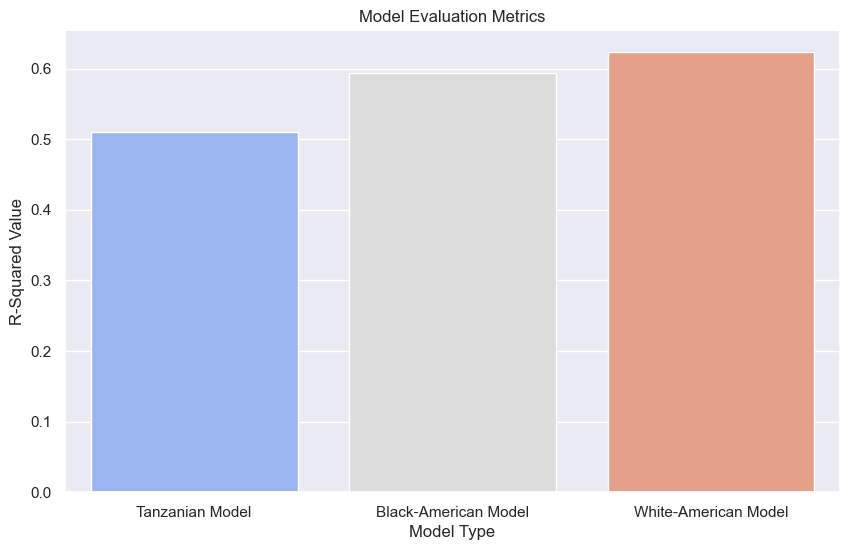

C:\Users\sko14\AppData\Local\Temp\ipykernel_23252\4218856283.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='Model Type', y='MSE', palette='coolwarm')


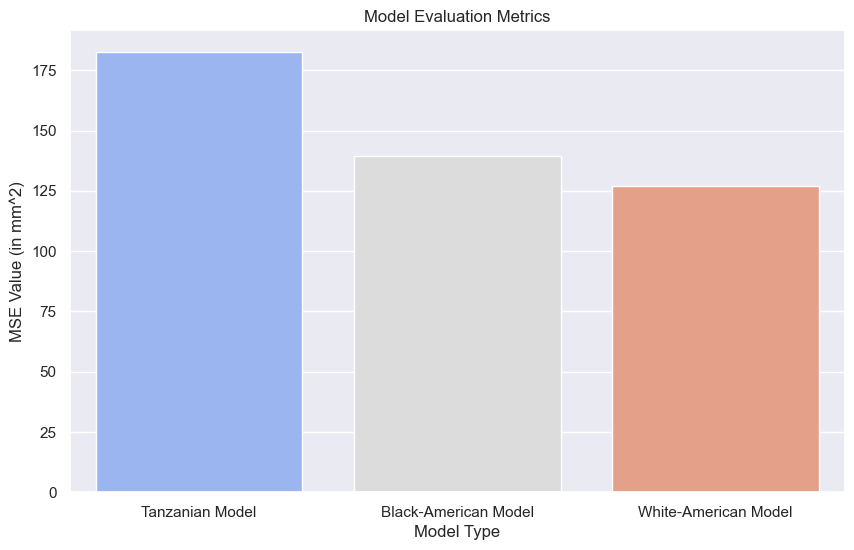

,Model Type,R_Squared,MSE
0,Tanzanian Model,0.510250,182.486707
1,Black-American Model,0.593185,139.607211
2,White-American Model,0.623044,127.092639


In [288]:
# Define the model names and their corresponding evaluation metrics
df_metrics = pd.DataFrame({
    'Model Type': ['Tanzanian Model',
                   'Black-American Model', 
                   'White-American Model'],
    'R_Squared': [tanzanian_r2, black_american_r2, white_american_r2],
    'MSE':[tanzanian_mse, black_american_mse,white_american_mse]
})

# Plot R-Squared values for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Model Type', y='R_Squared', palette='coolwarm')
plt.title('Model Evaluation Metrics')
plt.ylabel('R-Squared Value')
plt.show()

# Plot MSE values for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Model Type', y='MSE', palette='coolwarm')
plt.title('Model Evaluation Metrics')
plt.ylabel('MSE Value (in mm^2)')
plt.show()

df_metrics
